In [9]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.xception import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

In [10]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False ## Not trainable weights

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

In [11]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

In [4]:
X_1, y_1 = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [5]:
X_2, y_2 = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

In [6]:
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)

# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 22027.0059 - mae: 113.4003 - val_loss: 11725.7861 - val_mae: 76.2908
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - loss: 13384.5879 - mae: 78.9867 - val_loss: 7938.5010 - val_mae: 65.8968
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 10136.4492 - mae: 73.3956 - val_loss: 7778.0332 - val_mae: 69.3115
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - loss: 9643.8535 - mae: 74.9398 - val_loss: 7314.5332 - val_mae: 65.6011
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - loss: 8955.5918 - mae: 69.7077 - val_loss: 7008.0957 - val_mae: 63.2685
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 129s 7s/step - loss: 7850.2612 - mae: 66.0575 - val_loss: 6748.1909 - val_mae: 61.3438
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 129s 7s/step - loss: 7660.0034 - mae: 64.3032 - val_loss: 6536.3462 - val_mae: 59.8436
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - loss: 7089.6802 - mae: 60.5159 - val_loss: 6292.1387 - val_mae: 57.

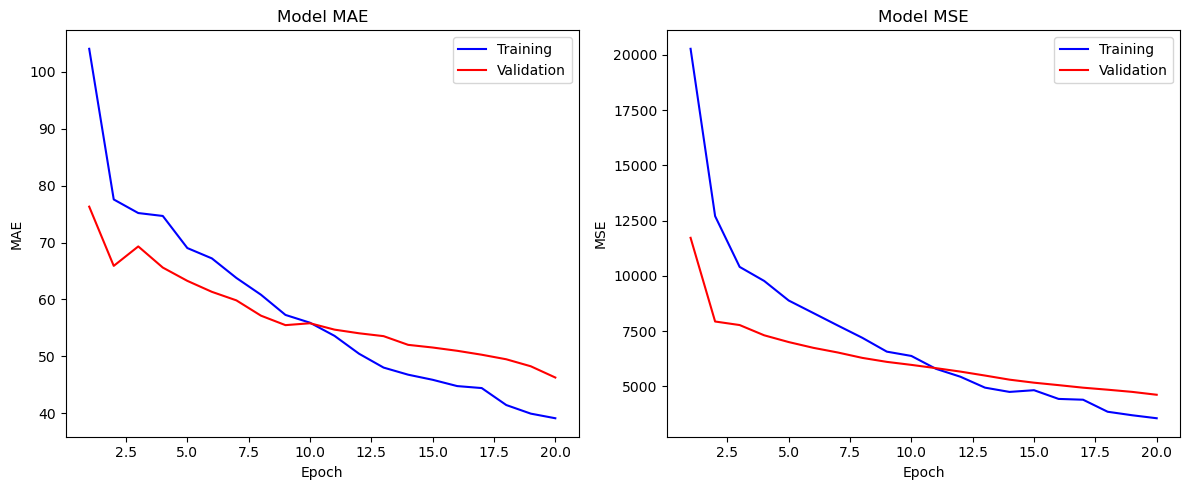

In [13]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
y_pred = np.round(model.predict(X_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [15]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[194. 156.]
 [121. 267.]
 [ 62.  86.]
 [184. 143.]
 [ 94.  54.]
 [134.  36.]
 [ 45.  48.]
 [ 53.  42.]
 [138. 118.]
 [ 91. 281.]
 [118. 106.]
 [ 59.  35.]
 [160. 138.]
 [193. 251.]
 [120. 123.]
 [181. 146.]
 [ 97.  74.]
 [147. 129.]
 [ 88.  85.]
 [177. 176.]
 [ 92.  64.]
 [ 39.  28.]
 [ 80. 132.]
 [147.  93.]
 [199. 298.]
 [198. 217.]
 [ 82.  61.]
 [146. 111.]
 [116.  87.]
 [117.  53.]
 [108.  73.]
 [119.  94.]
 [143. 265.]
 [184. 166.]
 [ 34.  28.]
 [132.  68.]
 [134. 229.]
 [123. 165.]
 [ 31.  35.]
 [123.  66.]
 [ 87.  47.]
 [143. 132.]
 [109.  60.]
 [145. 150.]
 [ 53.  38.]
 [ 90.  79.]
 [185. 123.]
 [101.  57.]
 [ 69.  57.]
 [115.  94.]
 [ 85.  35.]
 [ 37.  21.]
 [ 87. 114.]
 [ 68. 203.]
 [ 65.  28.]
 [111.  51.]
 [171. 159.]
 [ 71.  36.]
 [ 42. 133.]
 [197. 155.]
 [ 88.  97.]
 [165. 277.]
 [ 60.  54.]
 [107.  25.]
 [ 39.  29.]
 [ 52.  80.]
 [ 41. 104.]
 [ 88. 107.]
 [115. 344.]
 [117. 205.]
 [ 49.  83.]
 [155. 132.]
 [ 54.  84.]
 [191. 164.]
 [ 79. 104.]
 [212. 142.]
 [189. 235.]

In [16]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.31595730781555176